In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [3]:
df = pd.read_csv('Market_listings.csv')

In [4]:
df.head()

,Index,Listing_Title,City,Date_Listed,Land_Area,Number_of_Bedrooms,Number_of_Bathrooms,Floor_Area_SQ_M,Capital_Value,Agency,Sale_method_cleaned,Type,Region,Bayleys
0,0,"11 Ridgedale Road, Millwater",Rodney,13/09/2022,627.0,4.0,2.0,219.0,1425000,Ray White,Auction,House,Auckland,0
1,8,"10 Rockpool Road, Orewa",Rodney,13/09/2022,362.0,5.0,4.0,NaN,1425000,Harcourts,Negotiation,House,Auckland,0
2,1,"69A Whatuwhiwhi Road, Karikari Peninsula",Far North,13/09/2022,2100.0,4.0,1.0,364.0,900000,Other,Asking Price,House,Northland,0
3,32,"20D Matthews Avenue, Kaitaia",Far North,13/09/2022,100.0,2.0,1.0,97.0,340000,Other,Asking Price,House,Northland,0
4,38,"5A Park Rd, Kaikohe",Far North,13/09/2022,NaN,3.0,1.0,NaN,235000,Other,Asking Price,House,Northland,0


In [5]:
df.columns

Index(['Index', 'Listing_Title', 'City', 'Date_Listed', 'Land_Area',
       'Number_of_Bedrooms', 'Number_of_Bathrooms', 'Floor_Area_SQ_M',
       'Capital_Value', 'Agency', 'Sale_method_cleaned', 'Type', 'Region',
       'Bayleys'],
      dtype='object')

In [6]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

In [7]:
Outliers_to_drop = detect_outliers(df,2, ['Land_Area',
       'Number_of_Bedrooms', 'Number_of_Bathrooms', 'Floor_Area_SQ_M',
       'Capital_Value'])

In [8]:
df.loc[Outliers_to_drop]

,Index,Listing_Title,City,Date_Listed,Land_Area,Number_of_Bedrooms,Number_of_Bathrooms,Floor_Area_SQ_M,Capital_Value,Agency,Sale_method_cleaned,Type,Region,Bayleys


In [9]:
# df = df.fillna(np.nan)

In [10]:
df.isnull().sum()

Index                       0
Listing_Title               0
City                        0
Date_Listed                 0
Land_Area              100322
Number_of_Bedrooms      70632
Number_of_Bathrooms     70520
Floor_Area_SQ_M        128097
Capital_Value               0
Agency                      0
Sale_method_cleaned         0
Type                        0
Region                      0
Bayleys                     0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236734 entries, 0 to 236733
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Index                236734 non-null  int64  
 1   Listing_Title        236734 non-null  object 
 2   City                 236734 non-null  object 
 3   Date_Listed          236734 non-null  object 
 4   Land_Area            136412 non-null  float64
 5   Number_of_Bedrooms   166102 non-null  float64
 6   Number_of_Bathrooms  166214 non-null  float64
 7   Floor_Area_SQ_M      108637 non-null  float64
 8   Capital_Value        236734 non-null  int64  
 9   Agency               236734 non-null  object 
 10  Sale_method_cleaned  236734 non-null  object 
 11  Type                 236734 non-null  object 
 12  Region               236734 non-null  object 
 13  Bayleys              236734 non-null  int64  
dtypes: float64(4), int64(3), object(7)
memory usage: 25.3+ MB


In [12]:
df.describe()

,Index,Land_Area,Number_of_Bedrooms,Number_of_Bathrooms,Floor_Area_SQ_M,Capital_Value,Bayleys
count,236734.000000,136412.000000,166102.000000,166214.000000,108637.000000,2.367340e+05,236734.000000
mean,118366.500000,944.893763,3.301231,1.570066,161.056537,1.001164e+06,0.087448
std,68339.363651,1237.469788,1.419718,1.026032,174.813361,5.768421e+06,0.282492
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.500000e+03,0.000000
25%,59183.250000,516.000000,3.000000,1.000000,100.000000,4.600000e+05,0.000000
50%,118366.500000,698.000000,3.000000,1.000000,140.000000,7.000000e+05,0.000000
75%,177549.750000,928.000000,4.000000,2.000000,198.000000,1.060000e+06,0.000000
max,236733.000000,63536.000000,121.000000,80.000000,15000.000000,1.200000e+09,1.000000


In [13]:
plt.style.use('fivethirtyeight')

c:\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for hi

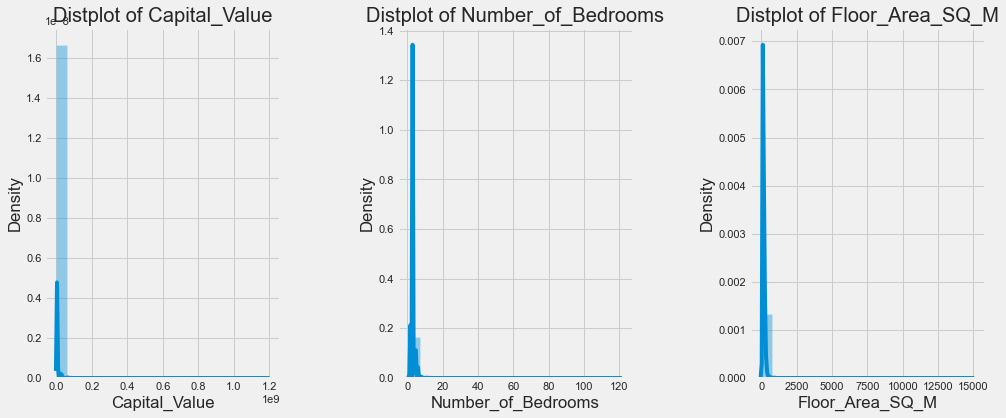

In [14]:
#Histogram
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['Capital_Value' , 'Number_of_Bedrooms' , 'Floor_Area_SQ_M']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(df[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show()

In [15]:
df = df.loc[ 
                    (df['Capital_Value'] >= 100000) &
                    (df['Capital_Value'] <= 2500000)
                     ]

In [16]:
df = df.loc[ 
                    (df['Number_of_Bedrooms'] <= 5)
                     ]

In [17]:
df = df.loc[ 
                    (df['Floor_Area_SQ_M'] <= 400)
                     ]

c:\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for hi

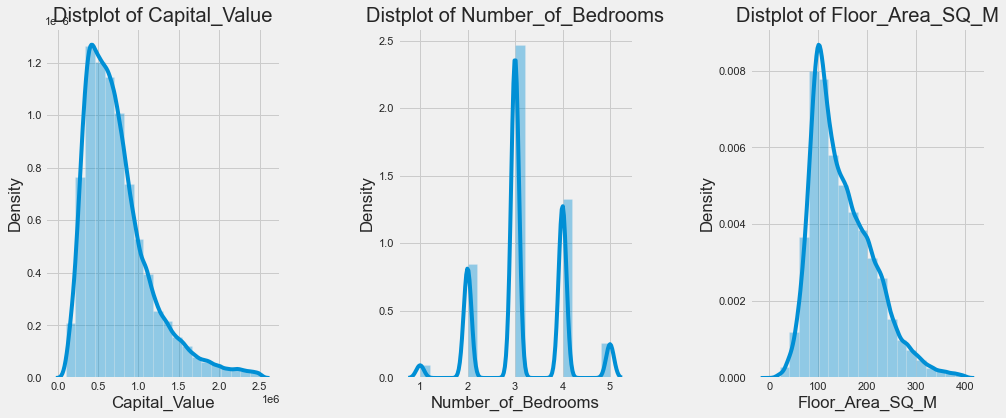

In [18]:
#Histogram
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['Capital_Value' , 'Number_of_Bedrooms' , 'Floor_Area_SQ_M']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(df[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show()

In [19]:
col_to_drop = ['Listing_Title','City','Date_Listed','Index','Agency']

In [20]:
df.drop(df[col_to_drop],  inplace = True, axis=1)

In [21]:
df.head()

,Land_Area,Number_of_Bedrooms,Number_of_Bathrooms,Floor_Area_SQ_M,Capital_Value,Sale_method_cleaned,Type,Region,Bayleys
0,627.0,4.0,2.0,219.0,1425000,Auction,House,Auckland,0
2,2100.0,4.0,1.0,364.0,900000,Asking Price,House,Northland,0
3,100.0,2.0,1.0,97.0,340000,Asking Price,House,Northland,0
5,542.0,3.0,1.0,114.0,800000,Negotiation,House,Auckland,0
15,882.0,2.0,1.0,65.0,840000,Deadline Sale,House,Auckland,0


In [22]:
df.isnull().sum()

Land_Area              19225
Number_of_Bedrooms         0
Number_of_Bathrooms        5
Floor_Area_SQ_M            0
Capital_Value              0
Sale_method_cleaned        0
Type                       0
Region                     0
Bayleys                    0
dtype: int64

In [23]:
df.fillna(df.mean(), inplace=True)

c:\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [24]:
df.dropna()

,Land_Area,Number_of_Bedrooms,Number_of_Bathrooms,Floor_Area_SQ_M,Capital_Value,Sale_method_cleaned,Type,Region,Bayleys
0,627.000000,4.0,2.0,219.0,1425000,Auction,House,Auckland,0
2,2100.000000,4.0,1.0,364.0,900000,Asking Price,House,Northland,0
3,100.000000,2.0,1.0,97.0,340000,Asking Price,House,Northland,0
5,542.000000,3.0,1.0,114.0,800000,Negotiation,House,Auckland,0
15,882.000000,2.0,1.0,65.0,840000,Deadline Sale,House,Auckland,0
...,...,...,...,...,...,...,...,...,...
236725,891.679601,3.0,2.0,120.0,800000,Asking Price,Apartment,Auckland,0
236726,445.000000,4.0,2.0,260.0,1275000,POA,House,Auckland,0
236730,1156.000000,3.0,2.0,115.0,1595000,Asking Price,House,Auckland,0
236731,645.000000,3.0,2.0,140.0,1425000,Asking Price,House,Auckland,0


In [25]:
df.isnull().sum()

Land_Area              0
Number_of_Bedrooms     0
Number_of_Bathrooms    0
Floor_Area_SQ_M        0
Capital_Value          0
Sale_method_cleaned    0
Type                   0
Region                 0
Bayleys                0
dtype: int64

In [26]:
df.columns

Index(['Land_Area', 'Number_of_Bedrooms', 'Number_of_Bathrooms',
       'Floor_Area_SQ_M', 'Capital_Value', 'Sale_method_cleaned', 'Type',
       'Region', 'Bayleys'],
      dtype='object')

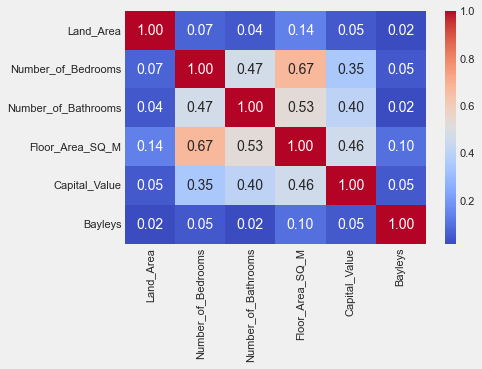

In [27]:
#Numerical values
g = sns.heatmap(df[['Land_Area', 'Number_of_Bedrooms', 'Number_of_Bathrooms',
       'Floor_Area_SQ_M', 'Capital_Value','Bayleys']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

c:\Python\Python37\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\Python\Python37\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


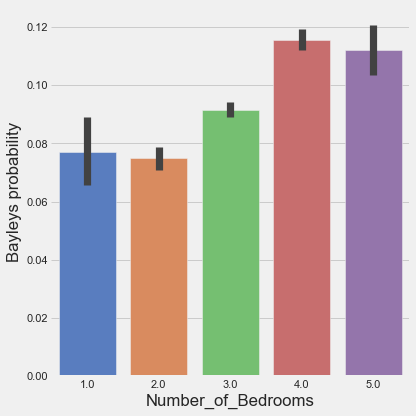

In [28]:
# Explore bedroom feature vs Bayleys
g = sns.factorplot(x="Number_of_Bedrooms",y="Bayleys",data=df,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Bayleys probability")

c:\Python\Python37\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\Python\Python37\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


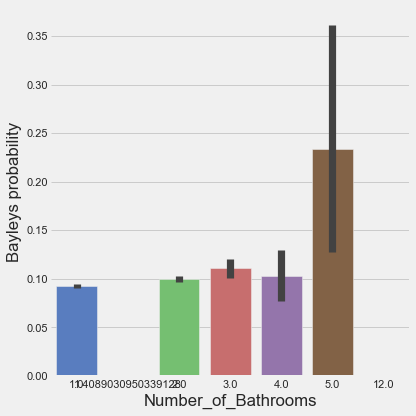

In [29]:
# Explore bathroom feature vs Bayleys
g = sns.factorplot(x="Number_of_Bathrooms",y="Bayleys",data=df,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Bayleys probability")

c:\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


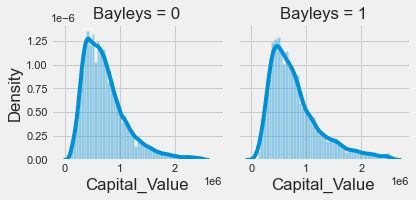

In [30]:
# Explore capital value vs Survived
g = sns.FacetGrid(df, col='Bayleys')
g = g.map(sns.distplot, "Capital_Value")

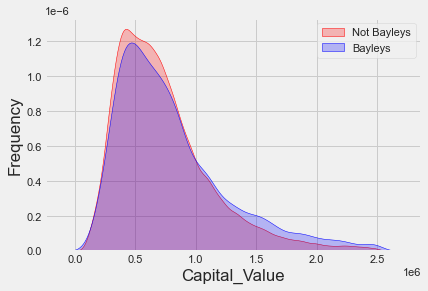

In [31]:
# Explore capital value distibution 
g = sns.kdeplot(df["Capital_Value"][(df["Bayleys"] == 0) & (df["Capital_Value"].notnull())], color="Red", shade = True)
g = sns.kdeplot(df["Capital_Value"][(df["Bayleys"] == 1) & (df["Capital_Value"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Capital_Value")
g.set_ylabel("Frequency")
g = g.legend(["Not Bayleys","Bayleys"])

c:\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


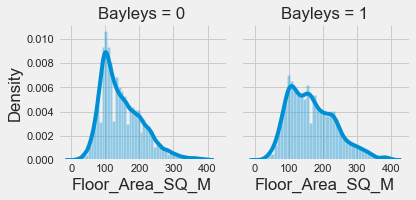

In [32]:
# Explore floor area vs Survived
g = sns.FacetGrid(df, col='Bayleys')
g = g.map(sns.distplot, "Floor_Area_SQ_M")

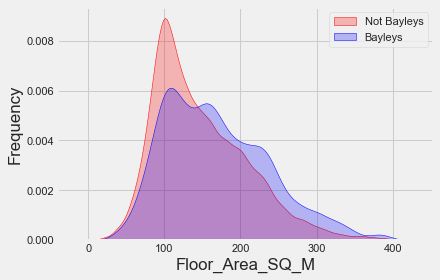

In [33]:
# Explore floor area distibution 
g = sns.kdeplot(df["Floor_Area_SQ_M"][(df["Bayleys"] == 0) & (df["Floor_Area_SQ_M"].notnull())], color="Red", shade = True)
g = sns.kdeplot(df["Floor_Area_SQ_M"][(df["Bayleys"] == 1) & (df["Floor_Area_SQ_M"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Floor_Area_SQ_M")
g.set_ylabel("Frequency")
g = g.legend(["Not Bayleys","Bayleys"])

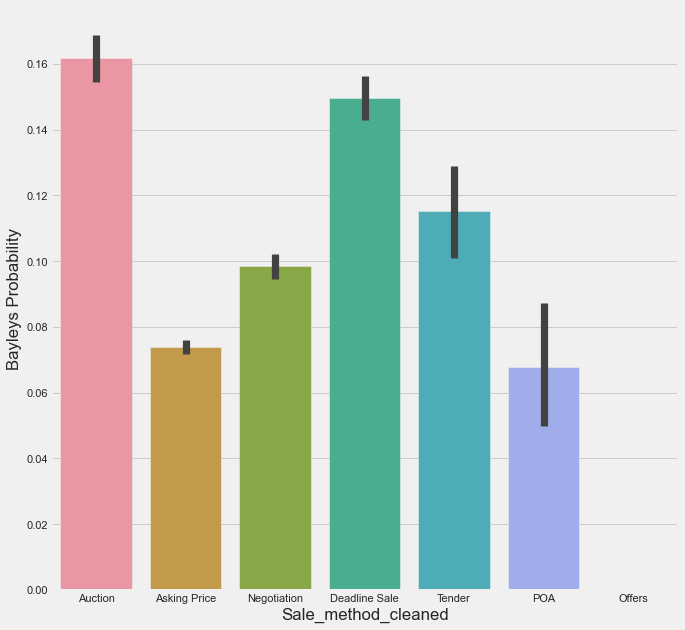

In [34]:
#Categorical values
#Sale method
fig, ax = plt.subplots(figsize=(10,10))
g = sns.barplot(x="Sale_method_cleaned",y="Bayleys",data=df)
g = g.set_ylabel("Bayleys Probability")

In [35]:
df[["Sale_method_cleaned","Bayleys"]].groupby('Sale_method_cleaned').mean()

,Bayleys
Sale_method_cleaned,
Asking Price,0.073778
Auction,0.161796
Deadline Sale,0.149809
Negotiation,0.098433
Offers,0.000000
POA,0.067961
Tender,0.115210


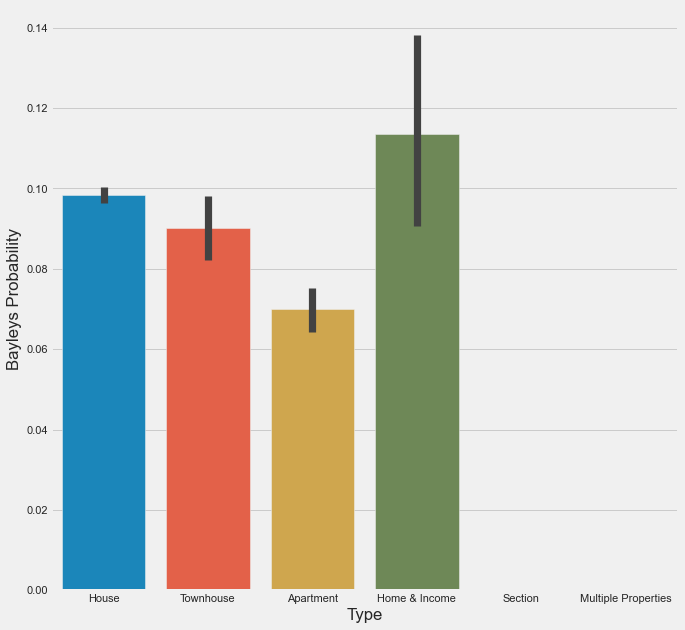

In [36]:
#Type
fig, ax = plt.subplots(figsize=(10,10))
g = sns.barplot(x="Type",y="Bayleys",data=df)
g = g.set_ylabel("Bayleys Probability")

In [37]:
df[["Type","Bayleys"]].groupby('Type').mean()

,Bayleys
Type,
Apartment,0.070007
Home & Income,0.113671
House,0.098317
Multiple Properties,0.000000
Section,0.000000
Townhouse,0.090221


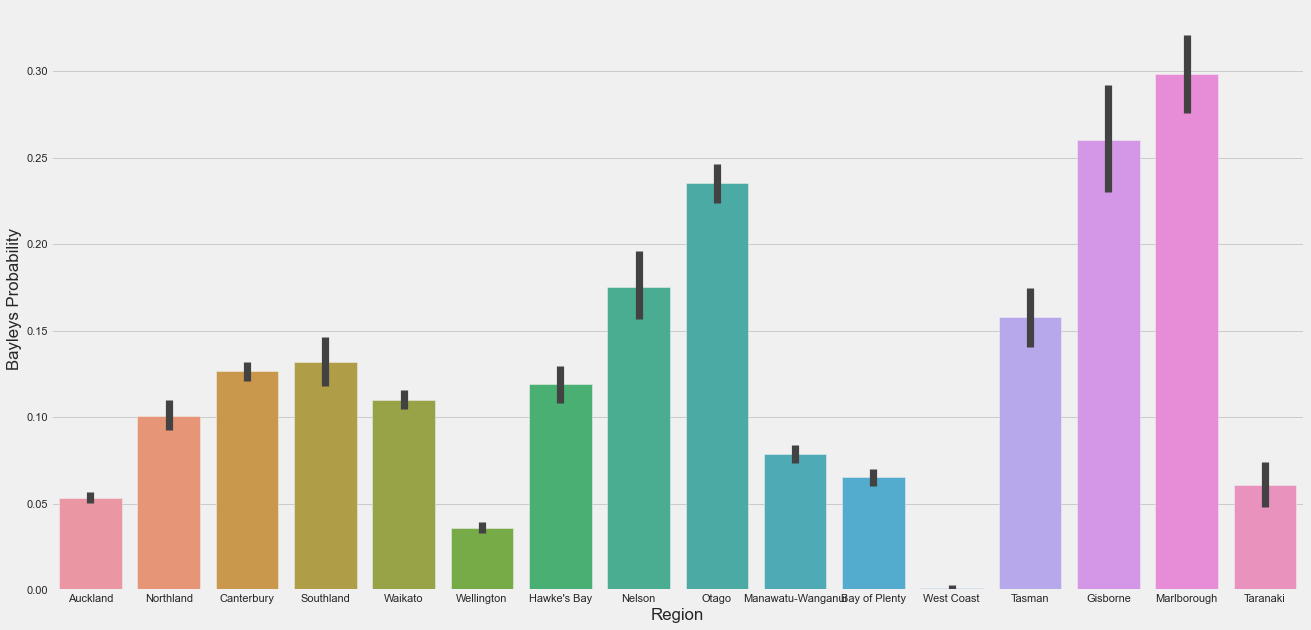

In [38]:
#Region
fig, ax = plt.subplots(figsize=(20,10))
g = sns.barplot(x="Region",y="Bayleys",data=df)
g = g.set_ylabel("Bayleys Probability")

In [39]:
df[["Region","Bayleys"]].groupby('Region').mean()

,Bayleys
Region,
Auckland,0.053574
Bay of Plenty,0.065179
Canterbury,0.126606
Gisborne,0.260430
Hawke's Bay,0.118997
Manawatu-Wanganui,0.078867
Marlborough,0.298701
Nelson,0.175251
Northland,0.100545


In [40]:
# convert to indicator values Title and Embarked 
df = pd.get_dummies(df, columns = ["Sale_method_cleaned"])
df = pd.get_dummies(df, columns = ["Type"])
df = pd.get_dummies(df, columns = ["Region"])

In [41]:
df.head()

,Land_Area,Number_of_Bedrooms,Number_of_Bathrooms,Floor_Area_SQ_M,Capital_Value,Bayleys,Sale_method_cleaned_Asking Price,Sale_method_cleaned_Auction,Sale_method_cleaned_Deadline Sale,Sale_method_cleaned_Negotiation,...,Region_Marlborough,Region_Nelson,Region_Northland,Region_Otago,Region_Southland,Region_Taranaki,Region_Tasman,Region_Waikato,Region_Wellington,Region_West Coast
0,627.0,4.0,2.0,219.0,1425000,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2100.0,4.0,1.0,364.0,900000,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,100.0,2.0,1.0,97.0,340000,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,542.0,3.0,1.0,114.0,800000,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
15,882.0,2.0,1.0,65.0,840000,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
#importing all the required ML packages
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix

In [43]:
train,test=train_test_split(df,test_size=0.3,random_state=0,stratify=df['Bayleys'])

In [44]:
train['Bayleys'] = train['Bayleys'].astype(int)
Y_train = train['Bayleys']
X_train = train.drop(labels=['Bayleys'], axis=1)

In [45]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

c:\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


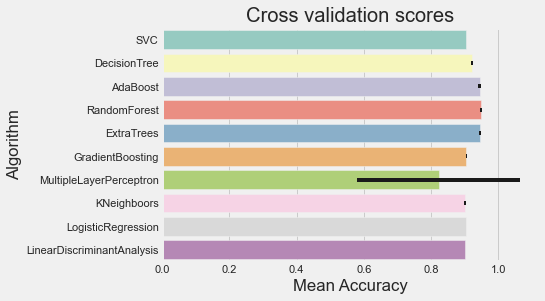

In [46]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [47]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


In [48]:
gsadaDTC.best_score_


0.9469471387063058

In [50]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.9478658353195355

In [51]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.9117966391352759

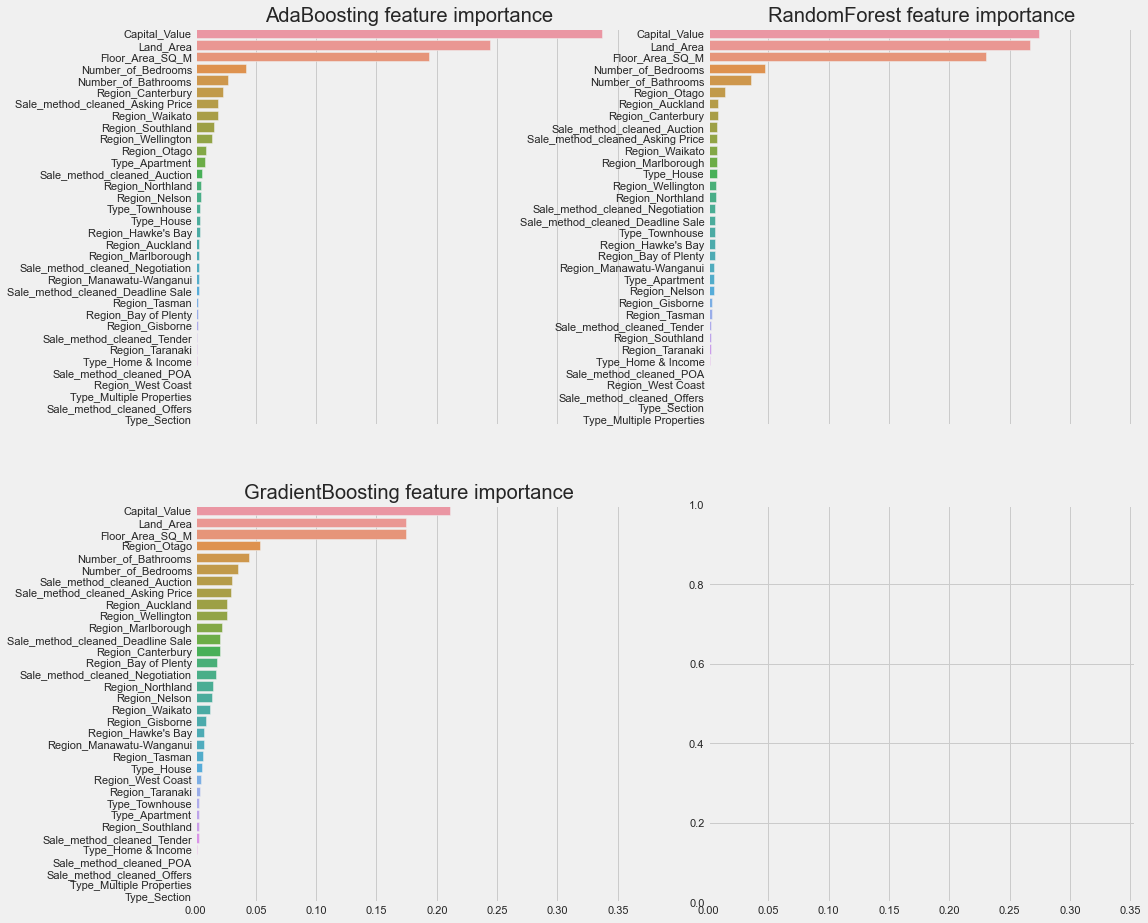

In [71]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
try:
    for row in range(nrows):
        for col in range(ncols):
            name = names_classifiers[nclassifier][0]
            classifier = names_classifiers[nclassifier][1]
            indices = np.argsort(classifier.feature_importances_)[::-1][:40]
            g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
            # g.set_xlabel("Relative importance",fontsize=12)
            # g.set_ylabel("Features",fontsize=12)
            # g.tick_params(labelsize=9)
            g.set_title(name + " feature importance")
            nclassifier += 1
except:
    pass